# Plot the latent dynamics (goverened by the ODE)

Load data from the data/rot_mnist/rot_mnist.mat

In [2]:
import scipy.io as sio
import numpy as np
import torch
from torch.utils import data
import os
import matplotlib.pyplot as plt
from data.utils import Dataset

/Users/ilze/PhD/virtualenv/env3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fullname = os.path.join('data', "rot_mnist", "rot-mnist.mat")
dataset = sio.loadmat(fullname)

X = np.squeeze(dataset['X'])
if True:
    Y = np.squeeze(dataset['Y'])
    X = X[Y==3,:,:]

N = 500
T = 16
Xtr   = torch.tensor(X[:N],dtype=torch.float32).view([N,T,1,28,28])
Xtest = torch.tensor(X[N:],dtype=torch.float32).view([-1,T,1,28,28])

# Generators
params = {'batch_size': 25, 'shuffle': True, 'num_workers': 2} #25
trainset = Dataset(Xtr)
trainset = data.DataLoader(trainset, **params)
testset  = Dataset(Xtest)
testset  = data.DataLoader(testset, **params)


Load models

In [3]:
from telnetlib import GA
import torch
from torch.distributions import MultivariateNormal 
from model.core.dsvpy import DSVGP_Layer
from model.core.flow import Flow
from model.core.distributions import Bernoulli, Multivariate_Standard
from model.core.vae import Encoder, Decoder
from model.core.odegpvae import ODEGPVAE

In [4]:
odegpvae = ODEGPVAE(flow=Flow(diffeq=DSVGP_Layer(D_in=8*2, D_out=8, M=100, S=256,dimwise=True, q_diag=False), solver='euler', use_adjoint=False),
                        enc_s =  Encoder(steps= 1),
                        enc_v = Encoder(steps = 5),
                        decoder = Decoder(),
                        num_observations= 25 * 16, #TODO N*T*D
                        likelihood=Bernoulli(),
                        prior =  MultivariateNormal(torch.zeros(8*2).to('cpu'),torch.eye(8*2).to('cpu')) ,
                        prior_q= MultivariateNormal(torch.zeros(8).to('cpu'),torch.eye(8).to('cpu')) ,
                        ts_dense_scale=2,
                        beta=1,
                        steps=5)
odegpvae_trace = ODEGPVAE(flow=Flow(diffeq=DSVGP_Layer(D_in=8*2, D_out=8, M=100, S=256,dimwise=True, q_diag=False), solver='euler', use_adjoint=False),
                        enc_s =  Encoder(steps= 1),
                        enc_v = Encoder(steps = 5),
                        decoder = Decoder(),
                        num_observations= 25 * 16, #TODO N*T*D
                        likelihood=Bernoulli(),
                        prior =  MultivariateNormal(torch.zeros(8*2).to('cpu'),torch.eye(8*2).to('cpu')) ,
                        prior_q= MultivariateNormal(torch.zeros(8).to('cpu'),torch.eye(8).to('cpu')) ,
                        ts_dense_scale=2,
                        beta=1,
                        steps=5)
odegpvae_notrace = ODEGPVAE(flow=Flow(diffeq=DSVGP_Layer(D_in=8*2, D_out=8, M=100, S=256,dimwise=True, q_diag=False), solver='euler', use_adjoint=False),
                        enc_s =  Encoder(steps= 1),
                        enc_v = Encoder(steps = 5),
                        decoder = Decoder(),
                        num_observations= 25 * 16, #TODO N*T*D
                        likelihood=Bernoulli(),
                        prior =  MultivariateNormal(torch.zeros(8*2).to('cpu'),torch.eye(8*2).to('cpu')) ,
                        prior_q= MultivariateNormal(torch.zeros(8).to('cpu'),torch.eye(8).to('cpu')) ,
                        ts_dense_scale=2,
                        beta=1,
                        steps=5)

odegpvae_ll = ODEGPVAE(flow=Flow(diffeq=DSVGP_Layer(D_in=8*2, D_out=8, M=100, S=256,dimwise=True, q_diag=False), solver='euler', use_adjoint=False),
                        enc_s =  Encoder(steps= 1),
                        enc_v = Encoder(steps = 5),
                        decoder = Decoder(),
                        num_observations= 25 * 16, #TODO N*T*D
                        likelihood=Bernoulli(),
                        prior =  MultivariateNormal(torch.zeros(8*2).to('cpu'),torch.eye(8*2).to('cpu')) ,
                        prior_q= MultivariateNormal(torch.zeros(8).to('cpu'),torch.eye(8).to('cpu')) ,
                        ts_dense_scale=2,
                        beta=1,
                        steps=5)
                        
odegpvae_1st = ODEGPVAE(flow=Flow(diffeq=DSVGP_Layer(D_in=8*2, D_out=16, M=100, S=256,dimwise=True, q_diag=False), solver='euler', use_adjoint=False, order=1),
                        enc_s =  Encoder(steps= 1, q=16),
                        enc_v = Encoder(steps = 5, q=16),
                        decoder = Decoder(q=16),
                        num_observations= 25 * 16, #TODO N*T*D
                        likelihood=Bernoulli(),
                        prior =  Multivariate_Standard(16).to('cpu') ,
                        prior_q= Multivariate_Standard(16).to('cpu') ,
                        ts_dense_scale=2,
                        beta=1,
                        steps=5,
                        order=1)



load models


In [5]:
fname = 'results/mnist_18_08_2022-13:00/odegpvae_mnist.pth'
odegpvae_trace.load_state_dict(torch.load(fname,map_location=torch.device('cpu')))
odegpvae_trace.eval()
fname = 'results/mnist_18_08_2022-13:02/odegpvae_mnist.pth'
odegpvae_notrace.load_state_dict(torch.load(fname,map_location=torch.device('cpu')))
odegpvae_notrace.eval()
fname = 'results/mnist_18_08_2022-22:59/odegpvae_mnist.pth'
odegpvae_ll.load_state_dict(torch.load(fname,map_location=torch.device('cpu')))
odegpvae_ll.eval()
fname = 'results/mnist_18_08_2022-13:04/odegpvae_mnist.pth'
odegpvae_1st.load_state_dict(torch.load(fname,map_location=torch.device('cpu')))
odegpvae_1st.eval()


ODEGPVAE(
  (flow): Flow(
    (odefunc): ODEfunc(
      (diffeq): DSVGP_Layer(
        (kern): RBF()
        (inducing_loc): Inducing locations parameter with Identity transformation
        (Um): Inducing distribution (mean) parameter with Identity transformation
        (Us_sqrt): Inducing distribution (scale) parameter with Lower cholesky transformation
      )
    )
  )
  (likelihood): Bernoulli()
  (enc_s): Encoder(
    (cnn): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (7): ReLU()
      (8): Flatten()
    )
    (fc1): Linear(in_features=512, out_features=16, bias=True)

In [6]:
from model.misc.plot_utils import *
test_batch = next(iter(testset))[:3,:].to('cpu') #sample 3 images

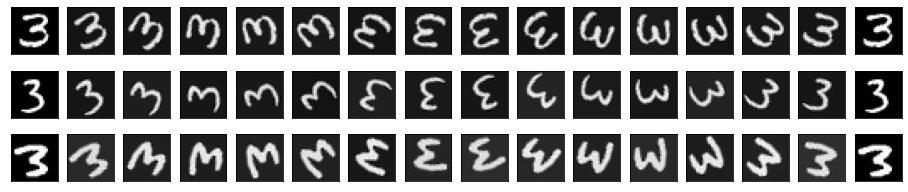

In [7]:
plt.figure(1,(20,8))
for j in range(3):
    for i in range(16):
        plt.subplot(7,20,j*20+i+1)
        plt.imshow(np.reshape(test_batch[j,i,:],[28,28]), cmap='gray');
        plt.xticks([]); plt.yticks([])
plt.show()

plot rollouts

/Users/ilze/PhD/github/OdeVaeGP/experiments/model/core/dsvpy.py:115: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1816.)
  Lu = torch.cholesky(Ku + torch.eye(self.M).to(self.device) * jitter)  # (M,M) or (D,M,M)
/Users/ilze/PhD/github/OdeVaeGP/experiments/model/core/dsvpy.py:123: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.

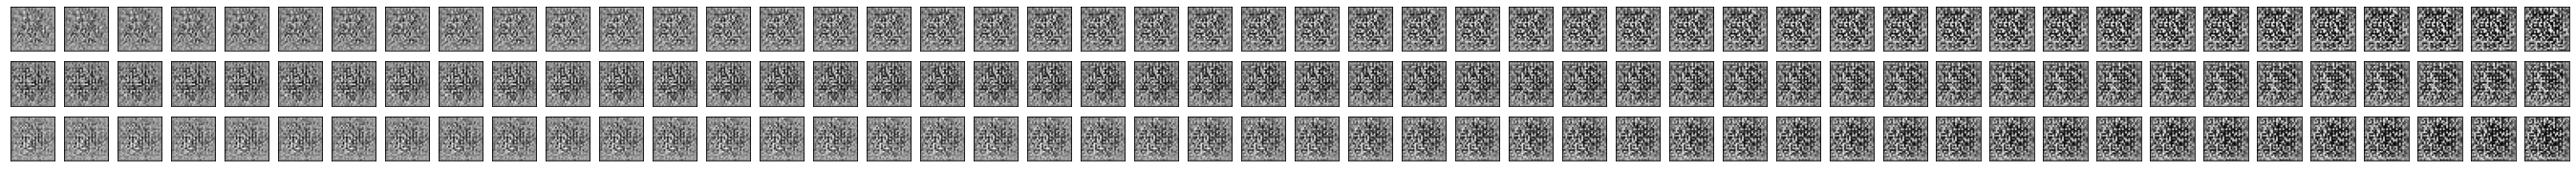

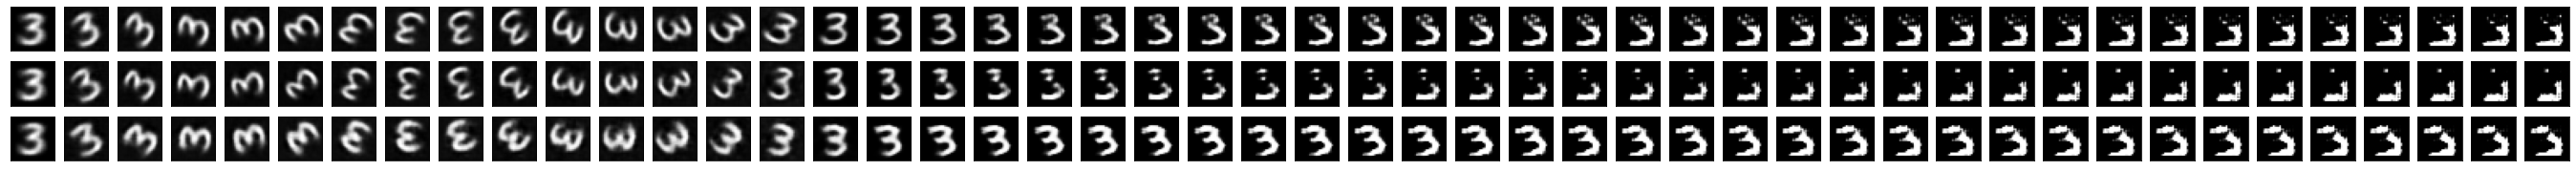

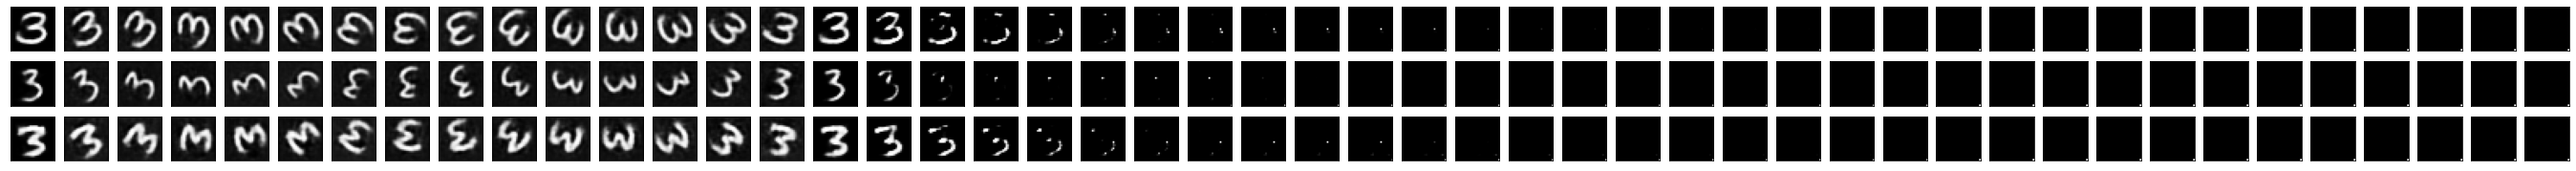

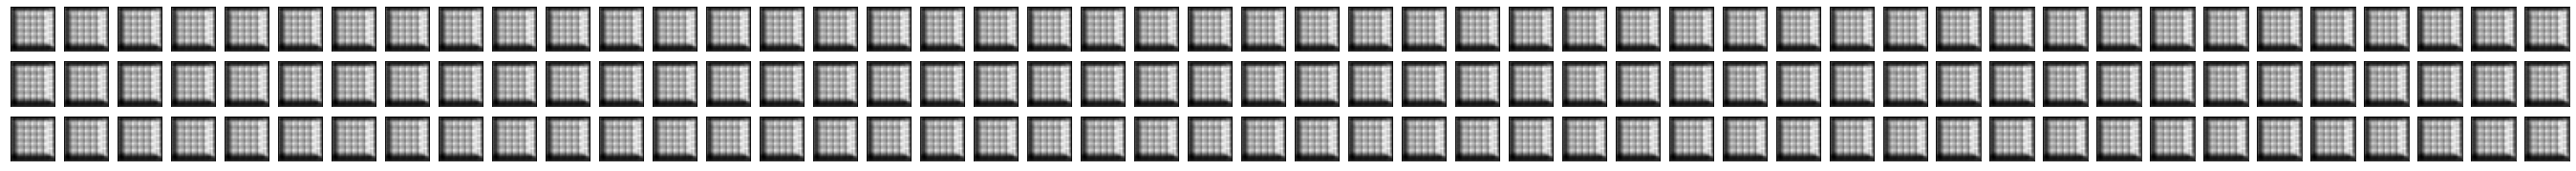

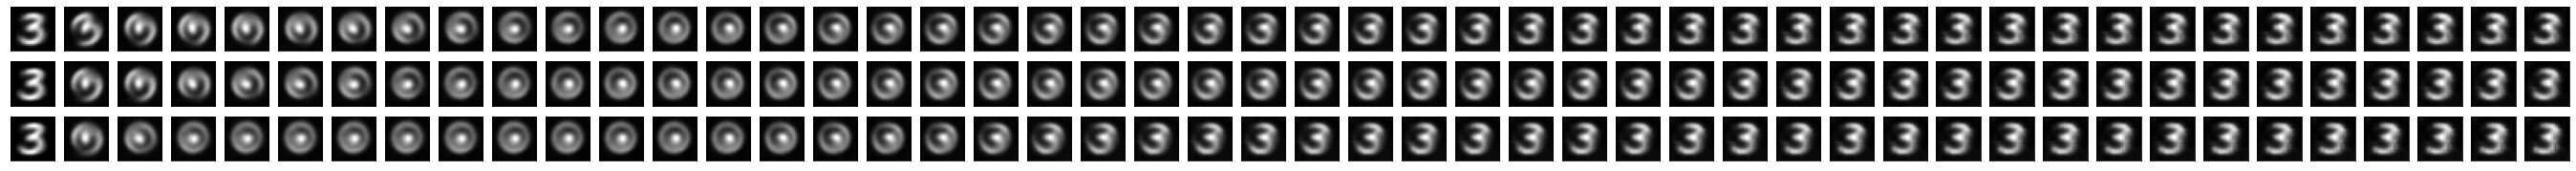

In [8]:
with torch.no_grad():    
    Xrec_mu, test_mse = odegpvae(test_batch, 3*T)
    plot_rollout(Xrec_mu,show=True)
    Xrec_mu, test_mse = odegpvae_trace(test_batch, 3*T)
    plot_rollout(Xrec_mu,show=True)
    Xrec_mu, test_mse = odegpvae_notrace(test_batch, 3*T)
    plot_rollout(Xrec_mu,show=True)
    Xrec_mu, test_mse = odegpvae_ll(test_batch, 3*T)
    plot_rollout(Xrec_mu,show=True)
    Xrec_mu, test_mse = odegpvae_1st(test_batch, 3*T)
    plot_rollout(Xrec_mu,show=True)


Without trace we obtain a better test MSE, 0.017 (no trace) vs 0.029 (with trace).


In [ ]:
Add the latent dynamics of rotation (curv-free)

# Plots for PCA investigation

In [8]:
from sklearn.decomposition import PCA

## Latent Dynamic Plotting

Pass the data through the encoder

In [5]:
#load a minibatch of data 
data_train = next(iter(trainset)) # N,T,nc,d,d
data_test = next(iter(testset)) # N,T,nc,d,d 

In [9]:
data_test[:3,:].shape

torch.Size([3, 16, 1, 28, 28])

check the data

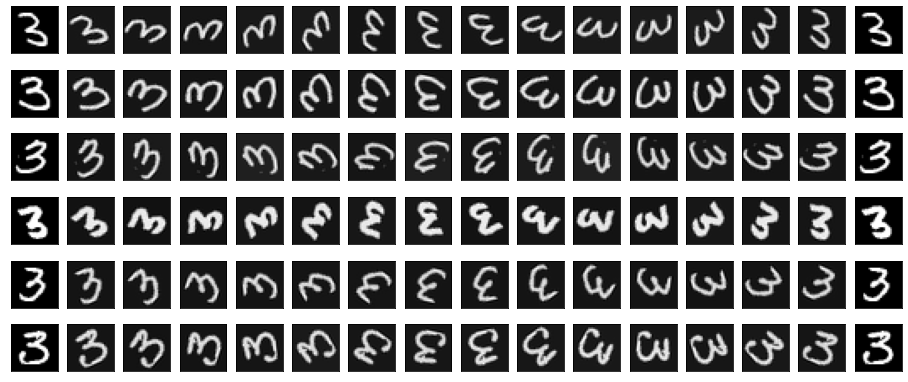

In [41]:
plt.figure(1,(20,8))
for j in range(6):
    for i in range(16):
        plt.subplot(7,20,j*20+i+1)
        plt.imshow(np.reshape(data_train[j,i,:],[28,28]), cmap='gray');
        plt.xticks([]); plt.yticks([])
plt.show()

In [22]:
[N,T,nc,d,d] = data_train.shape

## Option 1. Split the latent space into v and s 

In [13]:
def compute_latent(model,data, split=True):
    T=16
    #encode
    z0, logp0 = model.build_encoding(data)
    #compute the dynamics
    zt = model.build_flow(z0, logp0, T, trace=False) #N,T,2q
    if split:
        q=8
        st_mu = zt[:,:,q:] # N,T,q
        vt_mu = zt[:,:,:q] # N,T,q
        return st_mu, vt_mu
    else:
        return zt

In [14]:
zt = compute_latent(odegpvae_empty, data_train, split=False) #no training

In [ ]:
#first cache
odegpvae_empty.flow.odefunc.before_odeint(trace=False, rebuild_cache=True)
#then samle rhs
odegpvae_empty.flow.odefunc

In [16]:
F = plot_vector_field([t for t in range(16)],zt,odegpvae_empty.flow.odefunc) #X solution from the odeint , vdp the de, mu parameters

ValueError: too many values to unpack (expected 2)

In [ ]:
#first order ODE
def plot_vector_field(t, X, ode_rhs, L=1):
    N_ = 10

    F = ode_rhs(None,Z).detach().cpu().numpy()
    F /= ((F**2).sum(-1,keepdims=True))**(0.25) #0.25 #scale the data

    X = X.transpose(0,1)
    min_x,min_y = X.min(dim=0)[0].min(dim=0)[0].detach().cpu().numpy()
    max_x,max_y = X.max(dim=0)[0].max(dim=0)[0].detach().cpu().numpy()
    xs1_,xs2_ = np.meshgrid(np.linspace(min_x, max_x, N_),np.linspace(min_y, max_y, N_))
    Z = np.array([xs1_.T.flatten(), xs2_.T.flatten()]).T
    Z = torch.from_numpy(Z).float().to(X.device)
    Z = torch.stack([Z]*L)
    # F = ode_rhs(None,Z).detach().cpu().numpy()
    # F /= ((F**2).sum(-1,keepdims=True))**(0.25) #0.25 #scale the data

    Z  = Z.detach().cpu().numpy()
    t = t.detach().cpu().numpy()
    X = X.detach().cpu().numpy()

    fig = plt.figure(1,[15,7.5],constrained_layout=True)
    gs  = fig.add_gridspec(3, 3)
    ax1 = fig.add_subplot(gs[:, 0])

    ax1.set_xlabel('State $x_1$',fontsize=17)
    ax1.set_ylabel('State $x_2$',fontsize=17)
    ax1.tick_params(axis='x', labelsize=15)
    ax1.tick_params(axis='y', labelsize=15)
    for F_ in F:
        h1 = ax1.quiver(xs1_, xs2_, F_[:,0].reshape(N_,N_).T, F_[:,1].reshape(N_,N_).T, \
                    cmap=plt.cm.Blues)
    plt.legend([h1],['Vector field'],
            loc='lower right', fontsize=10, bbox_to_anchor=(1.5, 0.05))
    plt.title('Vector field', fontsize=12)
    plt.show()
    return F

In [15]:
def plot_vector_field(t, X, ode_rhs, L=1):
    N_ = 10

    F = ode_rhs(None,Z).detach().cpu().numpy()
    F /= ((F**2).sum(-1,keepdims=True))**(0.25) #0.25 #scale the data

    X = X.transpose(0,1)
    min_x,min_y = X.min(dim=0)[0].min(dim=0)[0].detach().cpu().numpy()
    max_x,max_y = X.max(dim=0)[0].max(dim=0)[0].detach().cpu().numpy()
    xs1_,xs2_ = np.meshgrid(np.linspace(min_x, max_x, N_),np.linspace(min_y, max_y, N_))
    Z = np.array([xs1_.T.flatten(), xs2_.T.flatten()]).T
    Z = torch.from_numpy(Z).float().to(X.device)
    Z = torch.stack([Z]*L)
    # F = ode_rhs(None,Z).detach().cpu().numpy()
    # F /= ((F**2).sum(-1,keepdims=True))**(0.25) #0.25 #scale the data

    Z  = Z.detach().cpu().numpy()
    t = t.detach().cpu().numpy()
    X = X.detach().cpu().numpy()

    fig = plt.figure(1,[15,7.5],constrained_layout=True)
    gs  = fig.add_gridspec(3, 3)
    ax1 = fig.add_subplot(gs[:, 0])

    ax1.set_xlabel('State $x_1$',fontsize=17)
    ax1.set_ylabel('State $x_2$',fontsize=17)
    ax1.tick_params(axis='x', labelsize=15)
    ax1.tick_params(axis='y', labelsize=15)
    for F_ in F:
        h1 = ax1.quiver(xs1_, xs2_, F_[:,0].reshape(N_,N_).T, F_[:,1].reshape(N_,N_).T, \
                    cmap=plt.cm.Blues)
    plt.legend([h1],['Vector field'],
            loc='lower right', fontsize=10, bbox_to_anchor=(1.5, 0.05))
    plt.title('Vector field', fontsize=12)
    plt.show()
    return F

extract latents for models from different training points

In [12]:
st_mu_base, vt_mu_base = compute_latent(odegpvae_empty, data_train) #no training
st_mu_100, vt_mu_100 = compute_latent(odegpvae_100, data_train) #100 epochs
st_mu_200, vt_mu_200 = compute_latent(odegpvae_200, data_train) #200 epochs
st_mu_500, vt_mu_500 = compute_latent(odegpvae_500, data_train) #500 epochs

/Users/ilze/PhD/github/OdeVaeGP/experiments/model/core/dsvpy.py:114: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1816.)
  Lu = torch.cholesky(Ku + torch.eye(self.M).to(self.device) * jitter)  # (M,M) or (D,M,M)
/Users/ilze/PhD/github/OdeVaeGP/experiments/model/core/dsvpy.py:122: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.

### Option 1A: Fit a different pca for every time dimension

In [45]:
pca = PCA(n_components=2)

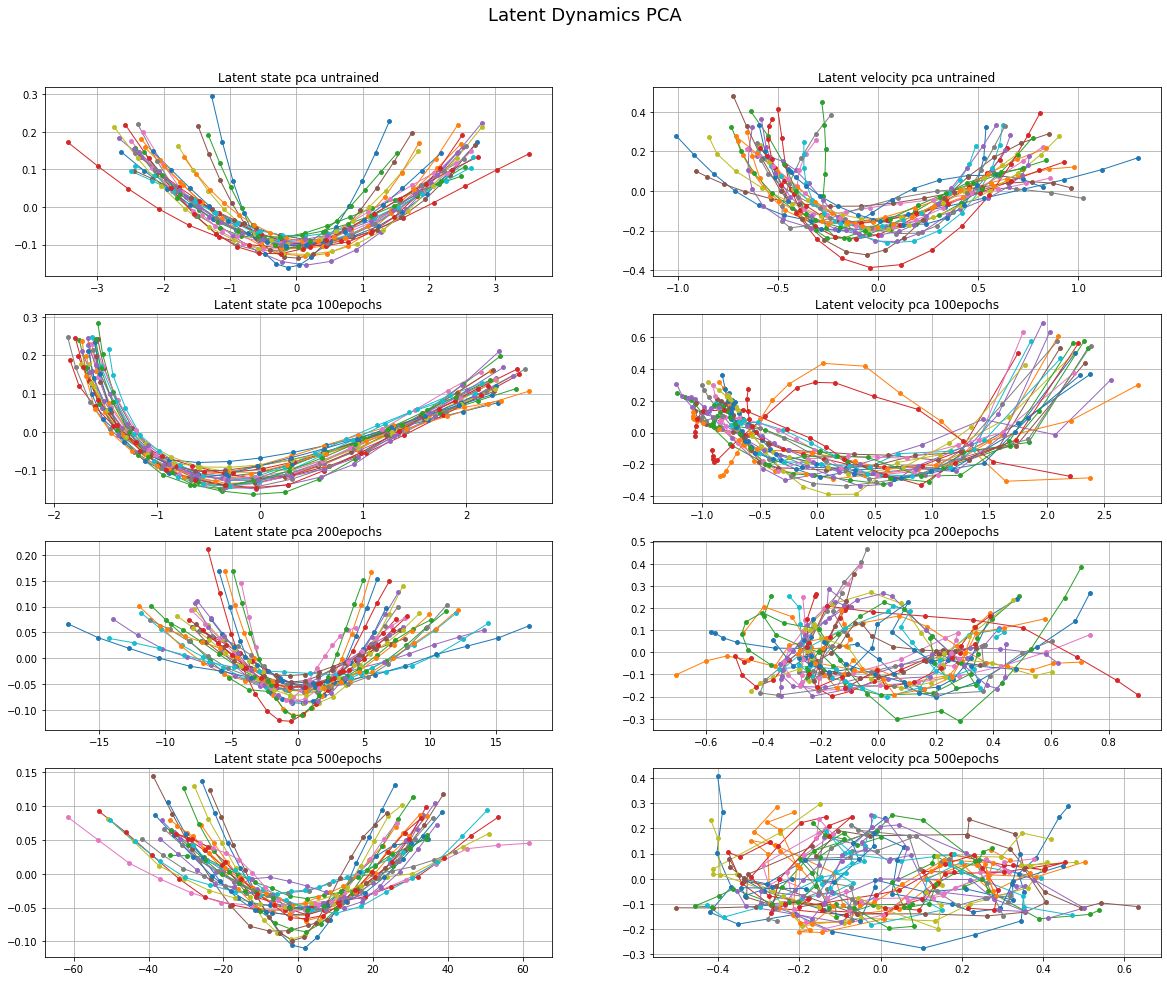

In [47]:
# create subplots
names = ['untrained', '100epochs', '200epochs','500epochs']
fig, axs = plt.subplots(nrows=4, ncols=2,figsize=(20, 16))
fig.suptitle("Latent Dynamics PCA", fontsize=18, y=0.95)
with torch.set_grad_enabled(False):
    for n in range(N):
        for i, data in zip(range(4), ((st_mu_base, vt_mu_base), (st_mu_100, vt_mu_100), (st_mu_200, vt_mu_200),(st_mu_500, vt_mu_500))):
            data_s, data_v = data
            s_pca = pca.fit_transform(data_s[n]) # T,2
            v_pca = pca.fit_transform(data_v[n]) # T,2
            axs[i][0].plot(s_pca[:,0],s_pca[:,1],lw=1)
            axs[i][0].scatter(s_pca[:,0],s_pca[:,1], s = 15, zorder=2.5)
            axs[i][1].plot(v_pca[:,0],v_pca[:,1],lw=1)
            axs[i][1].scatter(v_pca[:,0],v_pca[:,1], s = 15, zorder=2.5)
            axs[i][0].set_title('Latent state pca ' + names[i])
            axs[i][1].set_title('Latent velocity pca ' + names[i])
            axs[i][0].grid()
            axs[i][1].grid()
            
plt.show()

### Option 1B: Fit a pca for t=0 reuse for every time dimension

iteratively create pca models

In [19]:
dict_pca = {}
with torch.set_grad_enabled(False): 
    for n, data in zip(range(4), ((st_mu_base, vt_mu_base), (st_mu_100, vt_mu_100), (st_mu_200, vt_mu_200), (st_mu_500, vt_mu_500))):
        s, v = data
        dict_pca['pca_{}_s'.format(n)] = PCA(n_components=2).fit(s.reshape(N*T,8))
        dict_pca['pca_{}_v'.format(n)] = PCA(n_components=2).fit(v.reshape(N*T,8))

velocity (v1,t) & (v2,t)

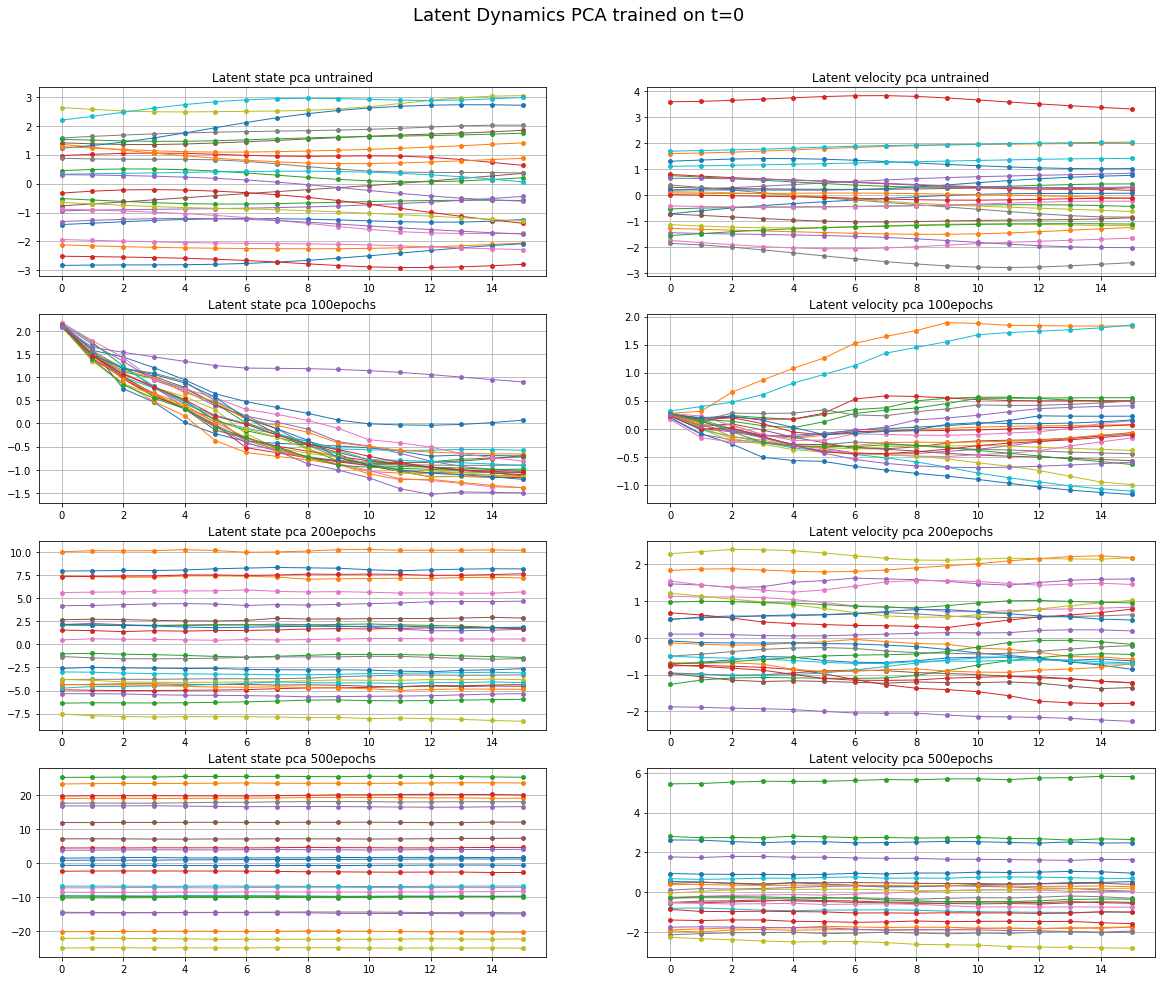

In [25]:
#create subplots
t = [t for t in range(T)]
names = ['untrained', '100epochs', '200epochs','500epochs']
fig, axs = plt.subplots(nrows=4, ncols=2,figsize=(20, 16))
fig.suptitle("Latent Dynamics PCA trained on t=0", fontsize=18, y=0.95)
with torch.set_grad_enabled(False):
    for n in range(N):
        for i, data in zip(range(4), ((st_mu_base, vt_mu_base), (st_mu_100, vt_mu_100), (st_mu_200, vt_mu_200), (st_mu_500, vt_mu_500))):
            data_s, data_v = data
            s_pca = dict_pca['pca_{}_s'.format(i)].transform(data_s[n]) # T,2
            v_pca = dict_pca['pca_{}_v'.format(i)].transform(data_v[n]) # T,2
            axs[i][0].plot(t,v_pca[:,0],lw=1)
            axs[i][0].scatter(t,v_pca[:,0], s = 15, zorder=2.5)
            axs[i][1].plot(t,v_pca[:,1],lw=1)
            axs[i][1].scatter(t,v_pca[:,1], s = 15, zorder=2.5)
            axs[i][0].set_title('Latent state pca '+ names[i])
            axs[i][1].set_title('Latent velocity pca '+ names[i])
            axs[i][0].grid()
            axs[i][1].grid()
            
plt.show()

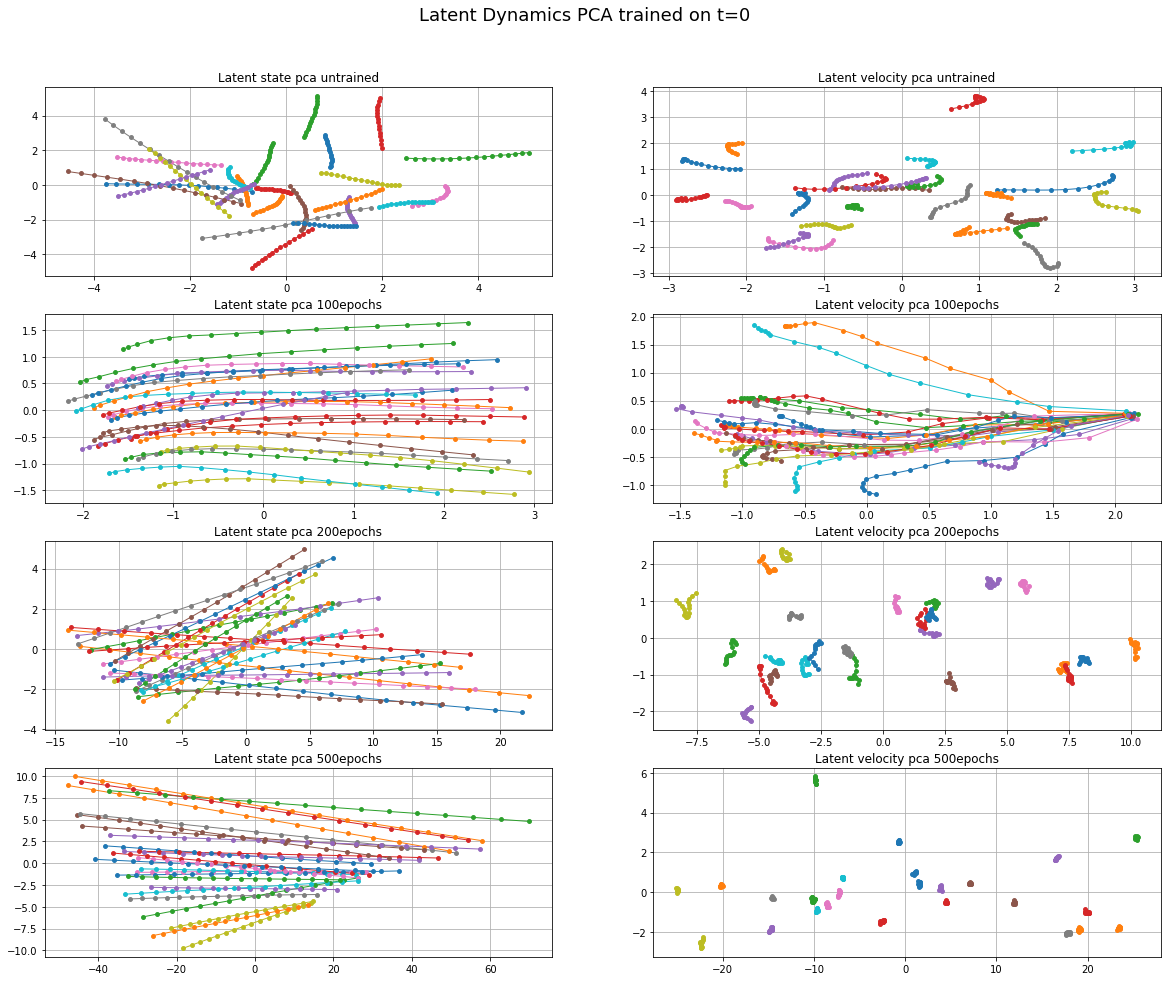

In [26]:
# create subplots
names = ['untrained', '100epochs', '200epochs','500epochs']
fig, axs = plt.subplots(nrows=4, ncols=2,figsize=(20, 16))
fig.suptitle("Latent Dynamics PCA trained on t=0", fontsize=18, y=0.95)
with torch.set_grad_enabled(False):
    for n in range(N):
        for i, data in zip(range(4), ((st_mu_base, vt_mu_base), (st_mu_100, vt_mu_100), (st_mu_200, vt_mu_200), (st_mu_500, vt_mu_500))):
            data_s, data_v = data
            s_pca = dict_pca['pca_{}_s'.format(i)].transform(data_s[n]) # T,2
            v_pca = dict_pca['pca_{}_v'.format(i)].transform(data_v[n]) # T,2
            axs[i][0].plot(s_pca[:,0],s_pca[:,1],lw=1)
            axs[i][0].scatter(s_pca[:,0],s_pca[:,1], s = 15, zorder=2.5)
            axs[i][1].plot(v_pca[:,0],v_pca[:,1],lw=1)
            axs[i][1].scatter(v_pca[:,0],v_pca[:,1], s = 15, zorder=2.5)
            axs[i][0].set_title('Latent state pca '+ names[i])
            axs[i][1].set_title('Latent velocity pca '+ names[i])
            axs[i][0].grid()
            axs[i][1].grid()
            
plt.show()

one dim encoding, plotting (s,v)

In [29]:
dict_pca = {}
with torch.set_grad_enabled(False): 
    for n, data in zip(range(4), ((st_mu_base, vt_mu_base), (st_mu_100, vt_mu_100), (st_mu_200, vt_mu_200), (st_mu_500, vt_mu_500))):
        s, v = data
        dict_pca['pca_{}_s'.format(n)] = PCA(n_components=1).fit(s.reshape(N*T,8))
        dict_pca['pca_{}_v'.format(n)] = PCA(n_components=1).fit(v.reshape(N*T,8))

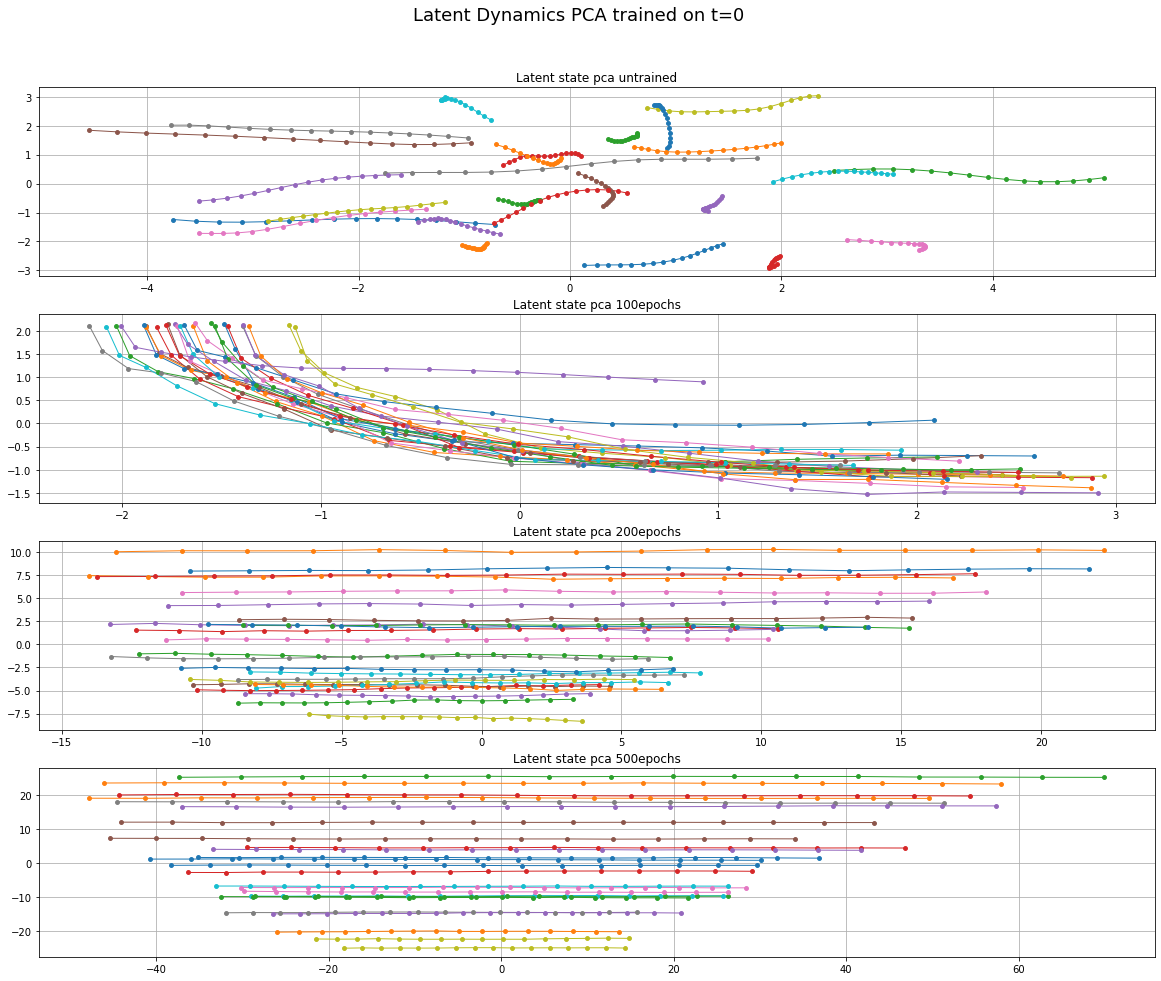

In [30]:
# create subplots
names = ['untrained', '100epochs', '200epochs','500epochs']
fig, axs = plt.subplots(nrows=4, ncols=1,figsize=(20, 16))
fig.suptitle("Latent Dynamics PCA trained on t=0", fontsize=18, y=0.95)
with torch.set_grad_enabled(False):
    for n in range(N):
        for i, data in zip(range(4), ((st_mu_base, vt_mu_base), (st_mu_100, vt_mu_100), (st_mu_200, vt_mu_200), (st_mu_500, vt_mu_500))):
            data_s, data_v = data
            s_pca = dict_pca['pca_{}_s'.format(i)].transform(data_s[n]) # T,1
            v_pca = dict_pca['pca_{}_v'.format(i)].transform(data_v[n]) # T,1
            axs[i].plot(s_pca,v_pca,lw=1)
            axs[i].scatter(s_pca,v_pca, s = 15, zorder=2.5)
            axs[i].set_title('Latent state pca '+ names[i])
            axs[i].grid()

            
plt.show()

## Option 2. Keep the latent space as single vector zt 

### Option 2A: Fit a different pca for every time dimension

In [50]:
zt_base = compute_latent(odegpvae_empty, data_train, split=False) #no training
zt_100 = compute_latent(odegpvae_100, data_train, split=False) #100 epochs
zt_200 = compute_latent(odegpvae_200, data_train, split=False) #200 epochs
zt_500  = compute_latent(odegpvae_500, data_train, split=False) #500 epochs

In [51]:
pca = PCA(n_components=2)

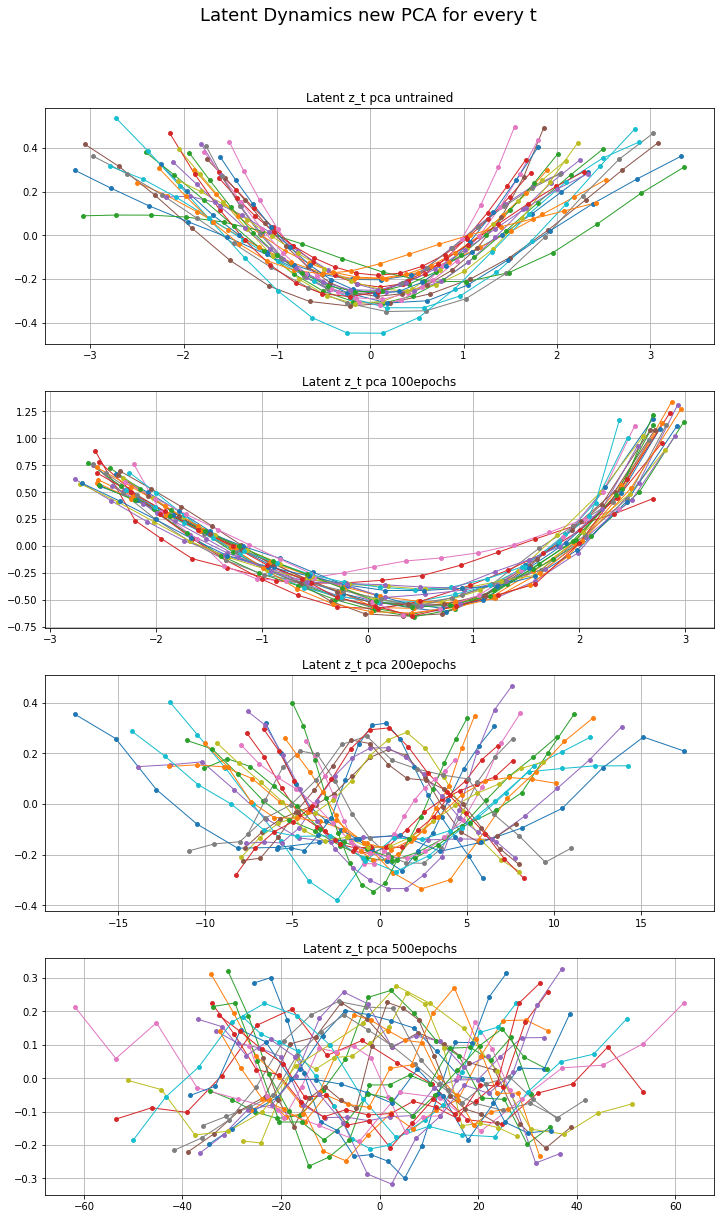

In [52]:
# create subplots
names = ['untrained', '100epochs', '200epochs', '500epochs']
fig, axs = plt.subplots(nrows=4, ncols=1,figsize=(12, 20))
fig.suptitle("Latent Dynamics new PCA for every t", fontsize=18, y=0.95)
with torch.set_grad_enabled(False):
    for n in range(N):
        for i, data_z in zip(range(4), (zt_base, zt_100, zt_200, zt_500)):
            z_pca = pca.fit_transform(data_z[n]) # T,2
            axs[i].plot(z_pca[:,0],z_pca[:,1],lw=1)
            axs[i].scatter(z_pca[:,0],z_pca[:,1], s = 15, zorder=2.5)
            axs[i].set_title('Latent z_t pca ' + names[i])
            axs[i].grid()


plt.show()

### Option 2B: Fit inttial pca for t=0, reuse for every time dimension

In [53]:
dict_pca_zt = {}
with torch.set_grad_enabled(False): 
    for n, data_zt in zip(range(4), (zt_base, zt_100, zt_200,zt_500)):
        dict_pca_zt['pca_{}_zt'.format(n)] = PCA(n_components=2).fit(data_zt[:,0])

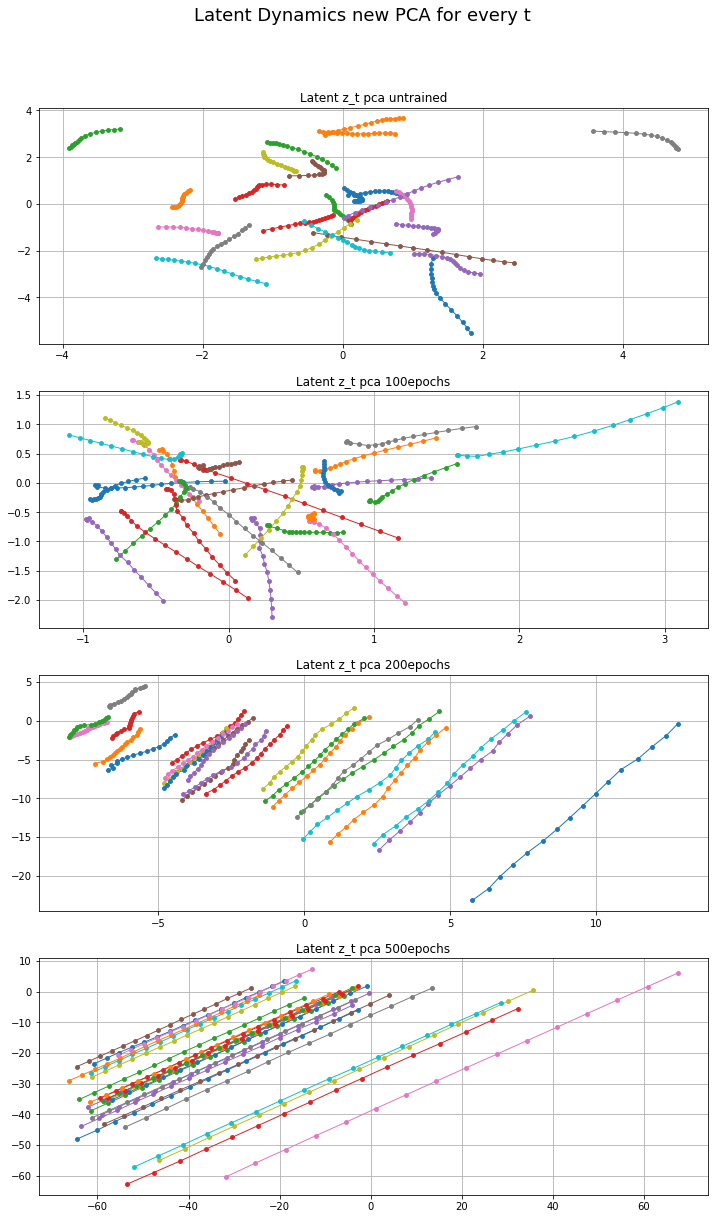

In [54]:
# create subplots
names = ['untrained', '100epochs', '200epochs', '500epochs']
fig, axs = plt.subplots(nrows=4, ncols=1,figsize=(12, 20))
fig.suptitle("Latent Dynamics new PCA for every t", fontsize=18, y=0.95)
with torch.set_grad_enabled(False):
    for n in range(N):
        for i, data_z in zip(range(4), (zt_base, zt_100, zt_200, zt_500)):
            z_pca = dict_pca_zt['pca_{}_zt'.format(i)].transform(data_z[n]) # T,2
            axs[i].plot(z_pca[:,0],z_pca[:,1],lw=1)
            axs[i].scatter(z_pca[:,0],z_pca[:,1], s = 15, zorder=2.5)
            axs[i].set_title('Latent z_t pca ' + names[i])
            axs[i].grid()
plt.show()